In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

In [2]:
max_features = 10000
max_len = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen = max_len)
x_test = sequence.pad_sequences(x_test, maxlen = max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\Bestc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\Bestc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [5]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length = max_len))
model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = RMSprop(learning_rate = 1e-4), loss = 'binary_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

In [6]:
model.save('C:/Workspace/python/Data_Science/dataA/분반(A반)/Deep Learning for text and sequences/1D_ConV_model1.h5')

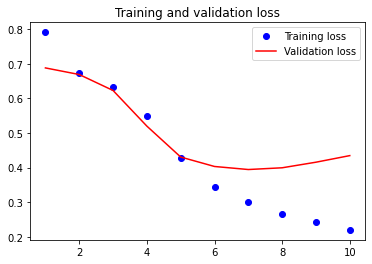

In [7]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [5]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [6]:
import os
data_dir = 'C:/Workspace/python/Data_Science/dataA/분반(A반)'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f= open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [7]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

In [8]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, 
              batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for k, row in enumerate(rows):
            indices = range(rows[k] - lookback, rows[k], step)
            samples[k] = data[indices]
            targets[k] = data[rows[k] + delay][1]
        yield samples, targets

In [9]:
step = 3
lookback = 1440
step = 6
delay = 144

train_gen = generator(float_data, lookback = lookback, 
                      delay = delay, min_index = 0, 
                      max_index = 200000, shuffle = True, 
                      step = step)

val_gen = generator(float_data, lookback = lookback, 
                      delay = delay, min_index = 200001, 
                      max_index = 300000, shuffle = True, 
                      step = step)

test_gen = generator(float_data, lookback = lookback, 
                      delay = delay, min_index = 300001, 
                      max_index = None, shuffle = True, 
                      step = step)

val_steps = (30000 - 20001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation = 'relu', input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.GRU(32, dropout = 0.1, recurrent_dropout = 0.5))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, validation_steps = val_steps)

C:\Users\Bestc\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 49s 92ms/step - loss: 0.3415 - val_loss: 0.3096
Epoch 2/20
500/500 [==============================] - 45s 90ms/step - loss: 0.3073 - val_loss: 0.3009
Epoch 3/20
500/500 [==============================] - 43s 87ms/step - loss: 0.2921 - val_loss: 0.2954
Epoch 4/20
500/500 [==============================] - 43s 85ms/step - loss: 0.2807 - val_loss: 0.2971
Epoch 5/20
500/500 [==============================] - 43s 85ms/step - loss: 0.2735 - val_loss: 0.3094
Epoch 6/20
500/500 [==============================] - 44s 89ms/step - loss: 0.2622 - val_loss: 0.3028
Epoch 7/20
500/500 [==============================] - 44s 89ms/step - loss: 0.2569 - val_loss: 0.2992
Epoch 8/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2505 - val_loss: 0.3168
Epoch 9/20
500/500 [==============================] - 42s 85ms/step - loss: 0.2436 - val_loss: 0.3134
Epoch 10/20
500/500 [==============================] - 44s 88ms/step - loss: 0.240

In [12]:
model.save('C:/Workspace/python/Data_Science/dataA/분반(A반)/Deep Learning for text and sequences/RNN_CNN_model1.h5')

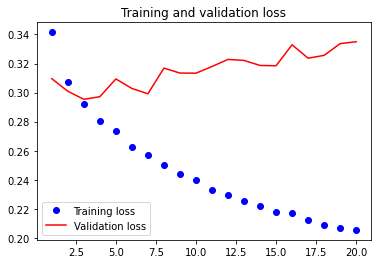

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# 학습도중 정확도가 정체되는 구간이 있을 시에 자동으로 중지하는 코드 : callback